In [1]:
import pandas as pd
from datasets import Dataset
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorWithPadding)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords as nltk_stopwords

# Загрузка размеченного датасета

In [ ]:
# 1. Загружаем данные
df = pd.read_csv('women_clothing.csv') # Колонки: 'review', 'label'
df_1 = df.loc[df['label'] == 0]
df_2 = df.loc[df['label'] == 1]
df_3 = df.loc[df['label'] == 2]

(30000, 2)

In [3]:
df_new = pd.concat([df_1[0:5000], df_2[0:5000], df_3[0:5000]], ignore_index=True)
df_new = df_new.sample(frac=1).reset_index(drop=True) #перемешать
df_new.shape

(15000, 2)

In [6]:
# будет необходимо для примера использования
test_df = pd.concat([df_1[5000:6000], df_2[5000:6000], df_3[5000:6000]], ignore_index=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.shape

(3000, 2)

# Предобработка отзывов

In [7]:
# Оставим в тексте только кириллические символы
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())

# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'хорошо', 'чтоб', 'том', 'из', 'на', 'этого', 'может', 'в', 'про', 'впрочем', 'чем', 'тоже', 'была', 'под', 'потом', 'ж', 'мне', 'перед', 'ее', 'только', 'себе', 'много', 'она', 'сам', 'есть', 'ней', 'меня', 'нас', 'так', 'всего', 'нельзя', 'ним', 'вас', 'хоть', 'были', 'когда', 'тот', 'раз', 'всех', 'все', 'этот', 'да', 'чуть', 'над', 'тебя', 'не', 'тем', 'он', 'опять', 'себя', 'свою', 'от', 'после', 'еще', 'какая', 'чего', 'сейчас', 'эту', 'конечно', 'ничего', 'был', 'без', 'уж', 'более', 'у', 'зачем', 'кто', 'а', 'я', 'них', 'вот', 'куда', 'там', 'чтобы', 'нибудь', 'тогда', 'никогда', 'наконец', 'вам', 'как', 'их', 'здесь', 'теперь', 'этой', 'или', 'ни', 'между', 'один', 'ты', 'эти', 'такой', 'даже', 'будто', 'бы', 'три', 'моя', 'можно', 'два', 'но', 'ну', 'ей', 'всегда', 'при', 'того', 'него', 'этом', 'нет', 'тут', 'почти', 'ли', 'быть', 'потому', 'другой', 'то', 'вы', 'если', 'до', 'больше', 'всю', 'о', 'разве', 'будет', 'по', 'им', 'они', 'какой', 'во', 'для', 'и', 'уже', 

In [8]:
import time
import re
# Очистим тексты отзывов
start_clean = time.time()

df_new['review'] = df_new['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 0.17 секунд


In [9]:
dataset = Dataset.from_pandas(df_new)

# 2. Загружаем токенизатор
model_name = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['review'], truncation=True, padding=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 4. Разделяем на train/test
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)

# 5. Загружаем модель с нужным количеством классов
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 6. Определяем метрики для оценки
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

In [14]:
# 7. Настраиваем гиперпараметры обучения
training_args = TrainingArguments(
    output_dir='./results_RT2_3_cl',          # Куда сохранять результаты
    eval_strategy="epoch",     # Оценивать после каждой эпохи
    learning_rate=5e-05,              # Скорость обучения (была 2e-5)
    per_device_train_batch_size=8,  # Размер батча
    per_device_eval_batch_size=8,
    num_train_epochs=3,              # Количество эпох
    weight_decay=0.01,               # Регуляризация
    save_strategy="epoch",
    logging_dir='./logs',
)

In [15]:
model.cuda() #убрать если отсутствует видеокарта в вашем ПК

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [16]:
# 8. Создаем Data Collator для динамического дополнения последовательностей
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 9. Создаем Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 10. Запускаем обучение!
trainer.train()

# 11. Сохраняем модель
trainer.save_model('./model_RT2_3_classes')

C:\Users\andre\AppData\Local\Temp\ipykernel_6988\223231489.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.685500,0.660130,0.707333,0.711181
2,0.601300,0.658763,0.710333,0.711163
3,0.536000,0.700074,0.711000,0.713056


In [17]:
import torch
model = AutoModelForSequenceClassification.from_pretrained('./model_RT2_3_classes')
tokenizer = AutoTokenizer.from_pretrained('./model_RT2_3_classes')

# Функция для предсказания настроения
def predict_sentiment(text):
    # Токенизируем текст и подготавливаем для модели
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    # Подаем на вход модели без вычисления градиентов (только инференс)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Получаем предсказания
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    
    # Находим индекс класса с максимальной вероятностью
    predicted_class_idx = predicted.argmax().item()
    sentiment = predicted_class_idx #classes[predicted_class_idx]
    confidence = predicted[0][predicted_class_idx].item()
    
    return sentiment, confidence

In [18]:
# Пример использования
# Очистим тексты отзывов
test_df['review'] = test_df['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

In [19]:
# примерно 4 сек на 1000 отзывов
test_df['prediction'] = test_df['review']\
        .apply(lambda x: predict_sentiment(str(x))[0])
test_df.head()

,review,label,prediction
0,качество оченькружево разошлось первой носке з...,0,0
1,пришла посылка достаточно быстоно размер девоч...,0,0
2,само качество штанов очень хорошеечуть прорези...,1,1
3,качество ткани нормальное прошито очень очень ...,0,1
4,первых заказ шёл очень долгоа пришёля разочаро...,0,0


In [22]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from plotly.subplots import make_subplots
import plotly.graph_objects as go

matrix = confusion_matrix(test_df['label'], test_df['prediction'])
print(matrix)

[[691 279  30]
 [250 640 110]
 [ 26 151 823]]


In [31]:
c = 0
for j in range(3):
    for i, row in test_df.iterrows():  
            if row['label'] == j and row['prediction'] == j+1:
                c += 1
    print(f'Количество истинных оценок {j}: 1000\
        Количество таких оценок предсказанных на 1 больше: {c}')
    c = 0

Количество истинных оценок 0: 1000        Количество таких оценок предсказанных на 1 больше: 279
Количество истинных оценок 1: 1000        Количество таких оценок предсказанных на 1 больше: 110
Количество истинных оценок 2: 1000        Количество таких оценок предсказанных на 1 больше: 0


In [33]:
c = 0
for j in range(3):
    for i, row in test_df.iterrows():  
            if row['label'] == j and row['prediction'] == j-1:
                c += 1
    print(f'Количество истинных оценок {j}: 1000\
        Количество таких оценок предсказанных на 1 меньше: {c}')
    c = 0

Количество истинных оценок 0: 1000        Количество таких оценок предсказанных на 1 меньше: 0
Количество истинных оценок 1: 1000        Количество таких оценок предсказанных на 1 меньше: 250
Количество истинных оценок 2: 1000        Количество таких оценок предсказанных на 1 меньше: 151


In [23]:
test_df['spread_distance'] = ((test_df['label'] - test_df['prediction']) ** 2)
test_df.head()

,review,label,prediction,spread_distance
0,качество оченькружево разошлось первой носке з...,0,0,0
1,пришла посылка достаточно быстоно размер девоч...,0,0,0
2,само качество штанов очень хорошеечуть прорези...,1,1,0
3,качество ткани нормальное прошито очень очень ...,0,1,1
4,первых заказ шёл очень долгоа пришёля разочаро...,0,0,0


In [24]:
dups = test_df.pivot_table(index = ['spread_distance'], aggfunc ='size')
print(dups)

spread_distance
0    2154
1     790
4      56
dtype: int64


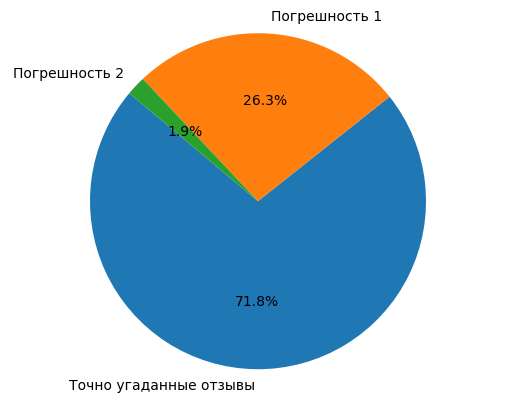

In [26]:
from matplotlib import pyplot as plt

sizes = [dups[0], dups[1], dups[4]]
labels = ['Точно угаданные отзывы', 'Погрешность 1', 'Погрешность 2']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140) 
plt.axis('equal')
plt.show() 

In [27]:
from sklearn.metrics import classification_report
accuracy = accuracy_score(test_df['label'], test_df['prediction'])
report = classification_report(test_df['label'], test_df['prediction'])

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.718
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1000
           1       0.60      0.64      0.62      1000
           2       0.85      0.82      0.84      1000

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000

